# Time Series Analysis of Light Curve Data from Kepler Space Probe


In [1]:
!pip install ssqueezepy wotan transitleastsquares astropy lightkurve

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


You should consider upgrading via the 'c:\users\prannaya\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for batman-package: filename=batman_package-2.4.8-cp37-cp37m-win_amd64.whl size=86270 sha256=d12c7f93983f2c4901da48bc9a1d3b72a142a61141d4d636e09373d10e69943b
  Stored in directory: c:\users\prannaya\appdata\local\pip\cache\wheels\97\50\fb\df66c5937af30045fded1ee31db1d58510ef4e2681d5b4590c
Successfully built batman-package


In [55]:
import numpy as np # main library for numeric calculations
import pandas as pd # main library for data analysis
import matplotlib.pyplot as plt # main library for data plotting
import seaborn as sns # Another library for data plotting with more functions

import scipy as scp # STEM software
from scipy import signal
import scipy.interpolate as interpolate

from glob import glob # check files
from IPython.display import display, Markdown

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import lightkurve as lk
import astropy

import wotan
from transitleastsquares import transitleastsquares as tls

from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow

"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)"""

import warnings
warnings.filterwarnings('ignore') # literally to ignore all the warnings that don't matter


def printf(*args, sep=" ", end="\n"):
    string = sep.join([str(i) for i in args])+end
    display(Markdown(string))



from lightkurve.lightcurve import KeplerLightCurve
import os
from typing import Union, List, Callable, Any

class LightCurve:
    def __init__(self, klc, kplrId):
        self.klc = klc
        self.id = kplrId

    def __enter__(self):
        return self
    
    def __repr__(self):
        return self.klc.__repr__()
    
    def __str__(self):
        return self.klc.__str__()

    def delete(self):
        os.remove(self.klc.meta["FILENAME"])

    def __del__(self):
        self.delete()

    def __exit__(self):
        self.__del__()

    def __getattr__(self, item):
        return eval(f"self.klc.{item}")


def retrieveKeplerLightCurve(kplrId):
    """
    :param kplrId: The Kepler Id, as an Integer, String or Float
    :returns: A KeplerLightCurve object
    """
    kplrId = int(kplrId)
    search_result: lk.SearchResult = lk.search_lightcurve(kplrId, author="Kepler", cadence="long")
    #lk.search_lightcurve(f'KIC {kplrId}', mission='Kepler', cadence="long", quarter=4)
    klc: KeplerLightCurve = search_result.download_all().stitch().remove_outliers()
    return LightCurve(klc, kplrId)


def analyseKeplerLightCurve(kplrId, func):
    """
    :param kplrId: The Kepler Id, as an Integer, String or Float
    :param func: The function to be ran, with the modified KeplerLightCurve as a parameter
    :return: Result of func
    """
    with retrieveKeplerLightCurve(kplrId) as klc:
        return func(klc)

def plotKeplerLightCurve(klc):
    """
    :param klc: The LightCurve object
    :returns: The axes upon which the data has been plotted
    """
    ax = klc.plot()
    ax.set_title(f"Light curve of KIC {klc.id}")
    return ax


def plotKeplerSAPLightCurve(klc):
    """
    :param klc: The LightCurve object
    :returns: The axes upon which the data has been plotted
    """
    ax = klc.plot(column='sap_flux', normalize=True)
    ax.set_title(f"SAP Flux Light curve of KIC {klc.id}")
    return ax


def plotKeplerPDCSAPLightCurve(klc):
    """
    :param klc: The LightCurve object
    :returns: The axes upon which the data has been plotted
    """
    ax = klc.plot(column='pdcsap_flux', normalize=True)
    ax.set_title(f"PDCSAP Flux Light curve of KIC {klc.id}")
    return ax


In [56]:
lc = retrieveKeplerLightCurve("Kepler-16")
lc

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.53888639700745,1.0006467e+00,5.8345737e-05,0,7.339770e-04,860.28248,250.68420,568,2.4600866e+05,1.4304771e+01,2.4442009e+03,9.5100969e-01,2.7584381e+05,1.6083908e+01,0,nan,nan,nan,nan,860.28248,6.2538878e-05,250.68420,8.1747392e-05,2.0588066e-03,-3.0079935e-04
120.55932059899351,1.0008476e+00,5.8160727e-05,10000000000000,7.345790e-04,860.28275,250.68436,569,2.4602658e+05,1.4305067e+01,2.4435254e+03,9.5061445e-01,2.7589919e+05,1.6032907e+01,10000000000000,nan,nan,nan,nan,860.28275,6.2534869e-05,250.68436,8.1741629e-05,2.2614349e-03,1.2032328e-04
120.57975470103702,1.0007442e+00,5.8213082e-05,0,7.351810e-04,860.28302,250.68444,570,2.4607181e+05,1.4304944e+01,2.4414873e+03,9.5106256e-01,2.7587069e+05,1.6047340e+01,0,nan,nan,nan,nan,860.28302,6.2520885e-05,250.68444,8.1730446e-05,2.5867678e-03,7.3683121e-05
120.60018900301657,1.0010390e+00,5.8081110e-05,0,7.357830e-04,860.28297,250.68414,571,2.4603252e+05,1.4305176e+01,2.4424441e+03,9.5002437e-01,2.7595197e+05,1.6010960e+01,0,nan,nan,nan,nan,860.28297,6.2536114e-05,250.68414,8.1740232e-05,2.5730261e-03,-2.6107472e-04
120.62062320506084,1.0004493e+00,5.7996342e-05,0,7.363851e-04,860.28363,250.68447,572,2.4605453e+05,1.4304453e+01,2.4445093e+03,9.5019072e-01,2.7578938e+05,1.5987593e+01,0,nan,nan,nan,nan,860.28363,6.2516978e-05,250.68447,8.1736274e-05,3.3388657e-03,1.4137170e-04
120.64105730704614,1.0009649e+00,5.8117635e-05,0,7.369870e-04,860.28350,250.68391,573,2.4607416e+05,1.4304874e+01,2.4414131e+03,9.5004946e-01,2.7593150e+05,1.6021029e+01,0,nan,nan,nan,nan,860.28350,6.2522035e-05,250.68391,8.1731887e-05,3.0998453e-03,-4.5700022e-04
120.66149150908313,1.0006875e+00,5.8037131e-05,0,7.375891e-04,860.28364,250.68426,574,2.4606734e+05,1.4304711e+01,2.4358105e+03,9.5103407e-01,2.7585503e+05,1.5998837e+01,0,nan,nan,nan,nan,860.28364,6.2571205e-05,250.68426,8.1745144e-05,3.4797832e-03,-1.0033309e-04
120.68192581106996,1.0006139e+00,5.8227026e-05,0,7.381911e-04,860.28366,250.68410,575,2.4605081e+05,1.4304349e+01,2.4421135e+03,9.4934106e-01,2.7583478e+05,1.6051184e+01,0,nan,nan,nan,nan,860.28366,6.2520761e-05,250.68410,8.1738086e-05,3.4442304e-03,-7.2624855e-05


In [57]:
lc.flux

<Quantity [1.0006467, 1.0008476, 1.0007442, ..., 1.009676 , 1.0095011,
           1.009595 ]>

<Figure size 2400x1200 with 0 Axes>

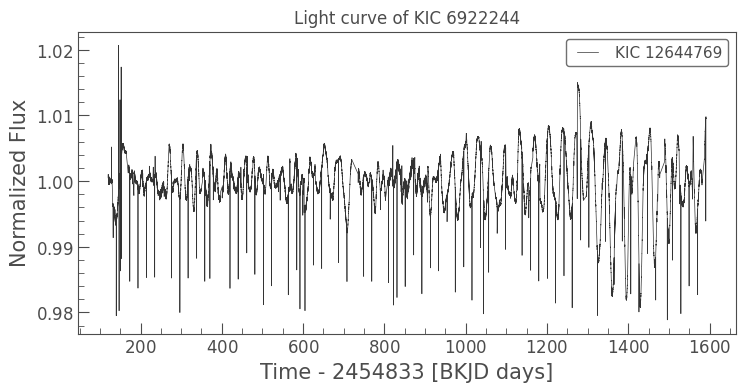

In [58]:
plt.figure(figsize=(16, 8))
plotKeplerLightCurve(lc)

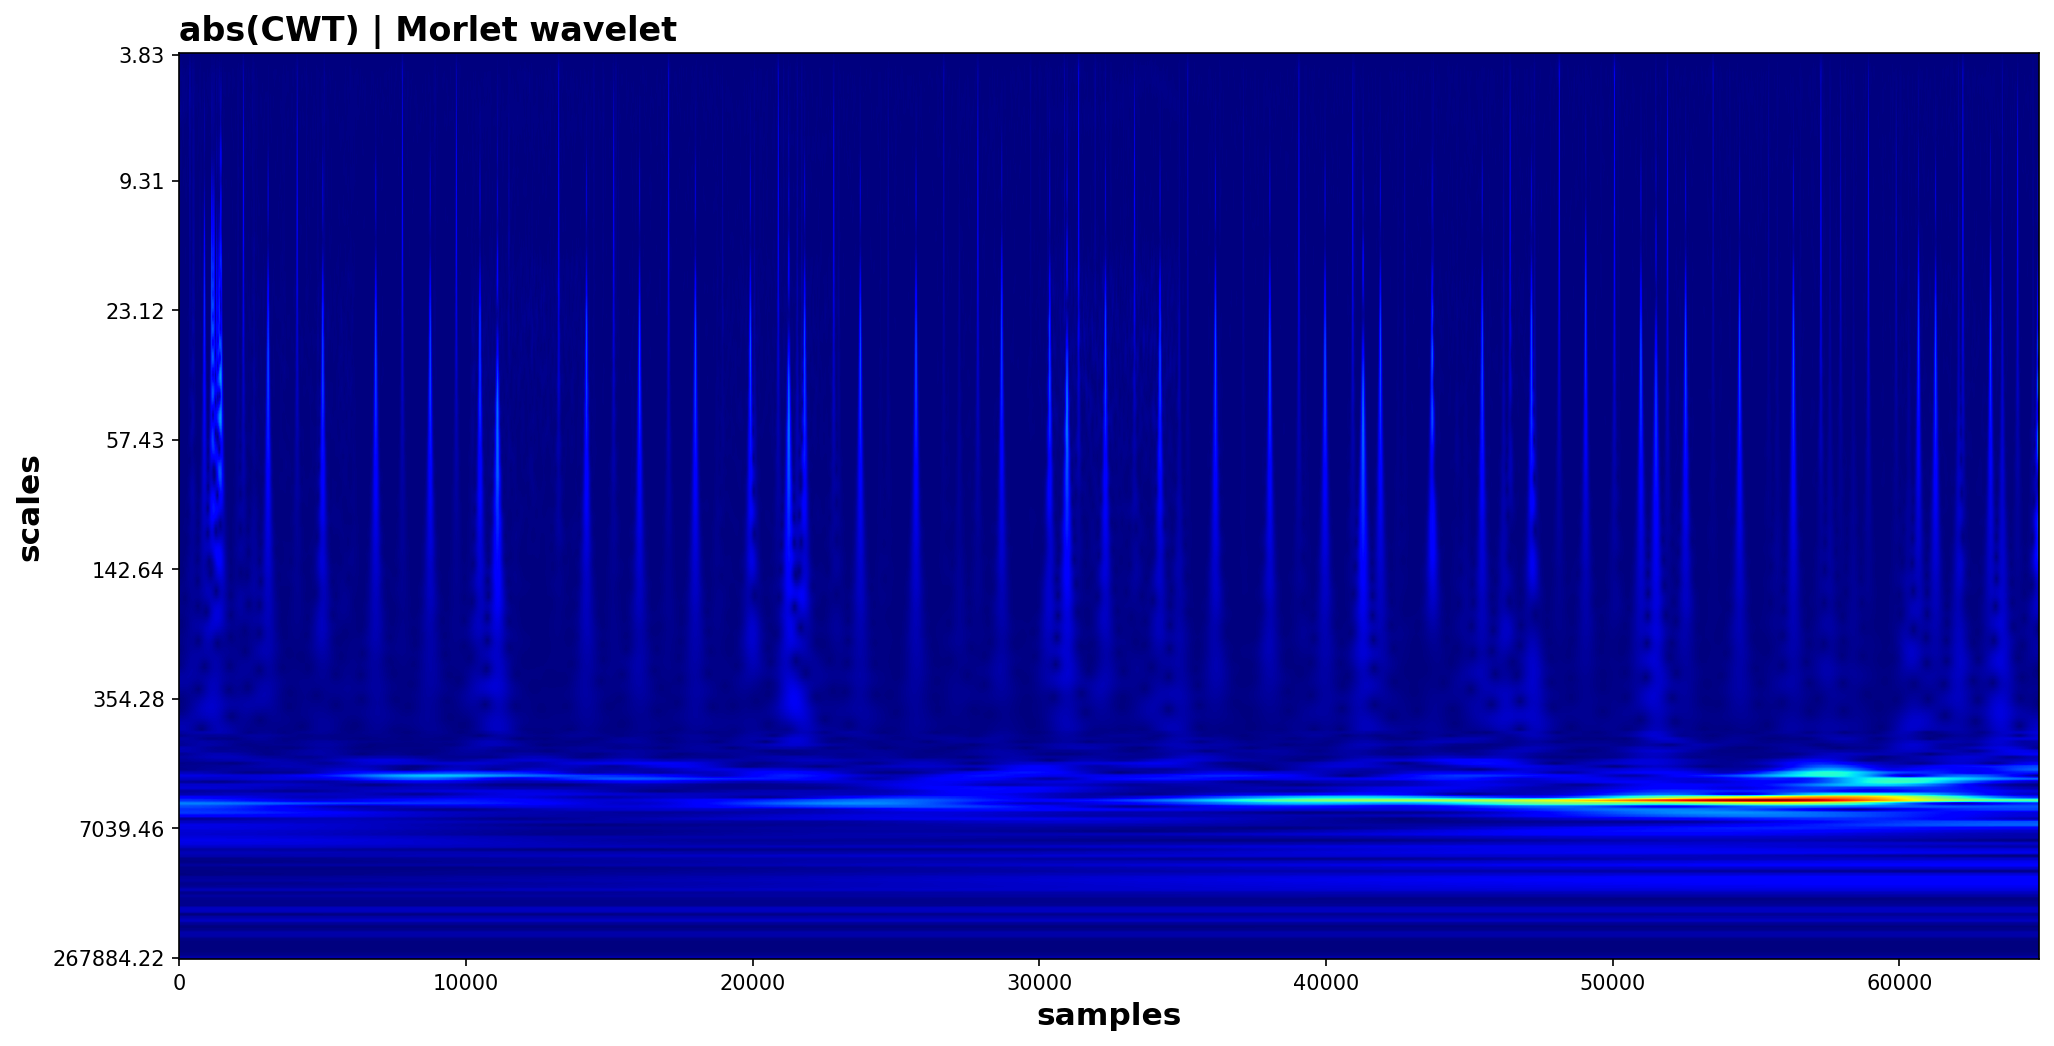

In [59]:
Wx, scales = cwt(np.array(lc.flux), 'morlet')
plt.figure(figsize=(16, 8))
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

<Figure size 2400x1200 with 0 Axes>

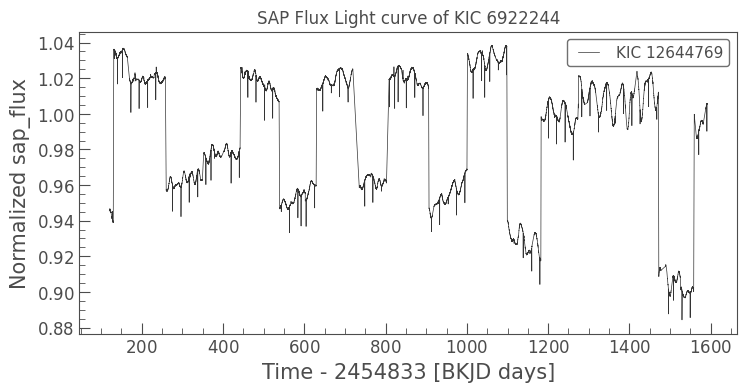

In [60]:
plt.figure(figsize=(16, 8))
plotKeplerSAPLightCurve(lc)

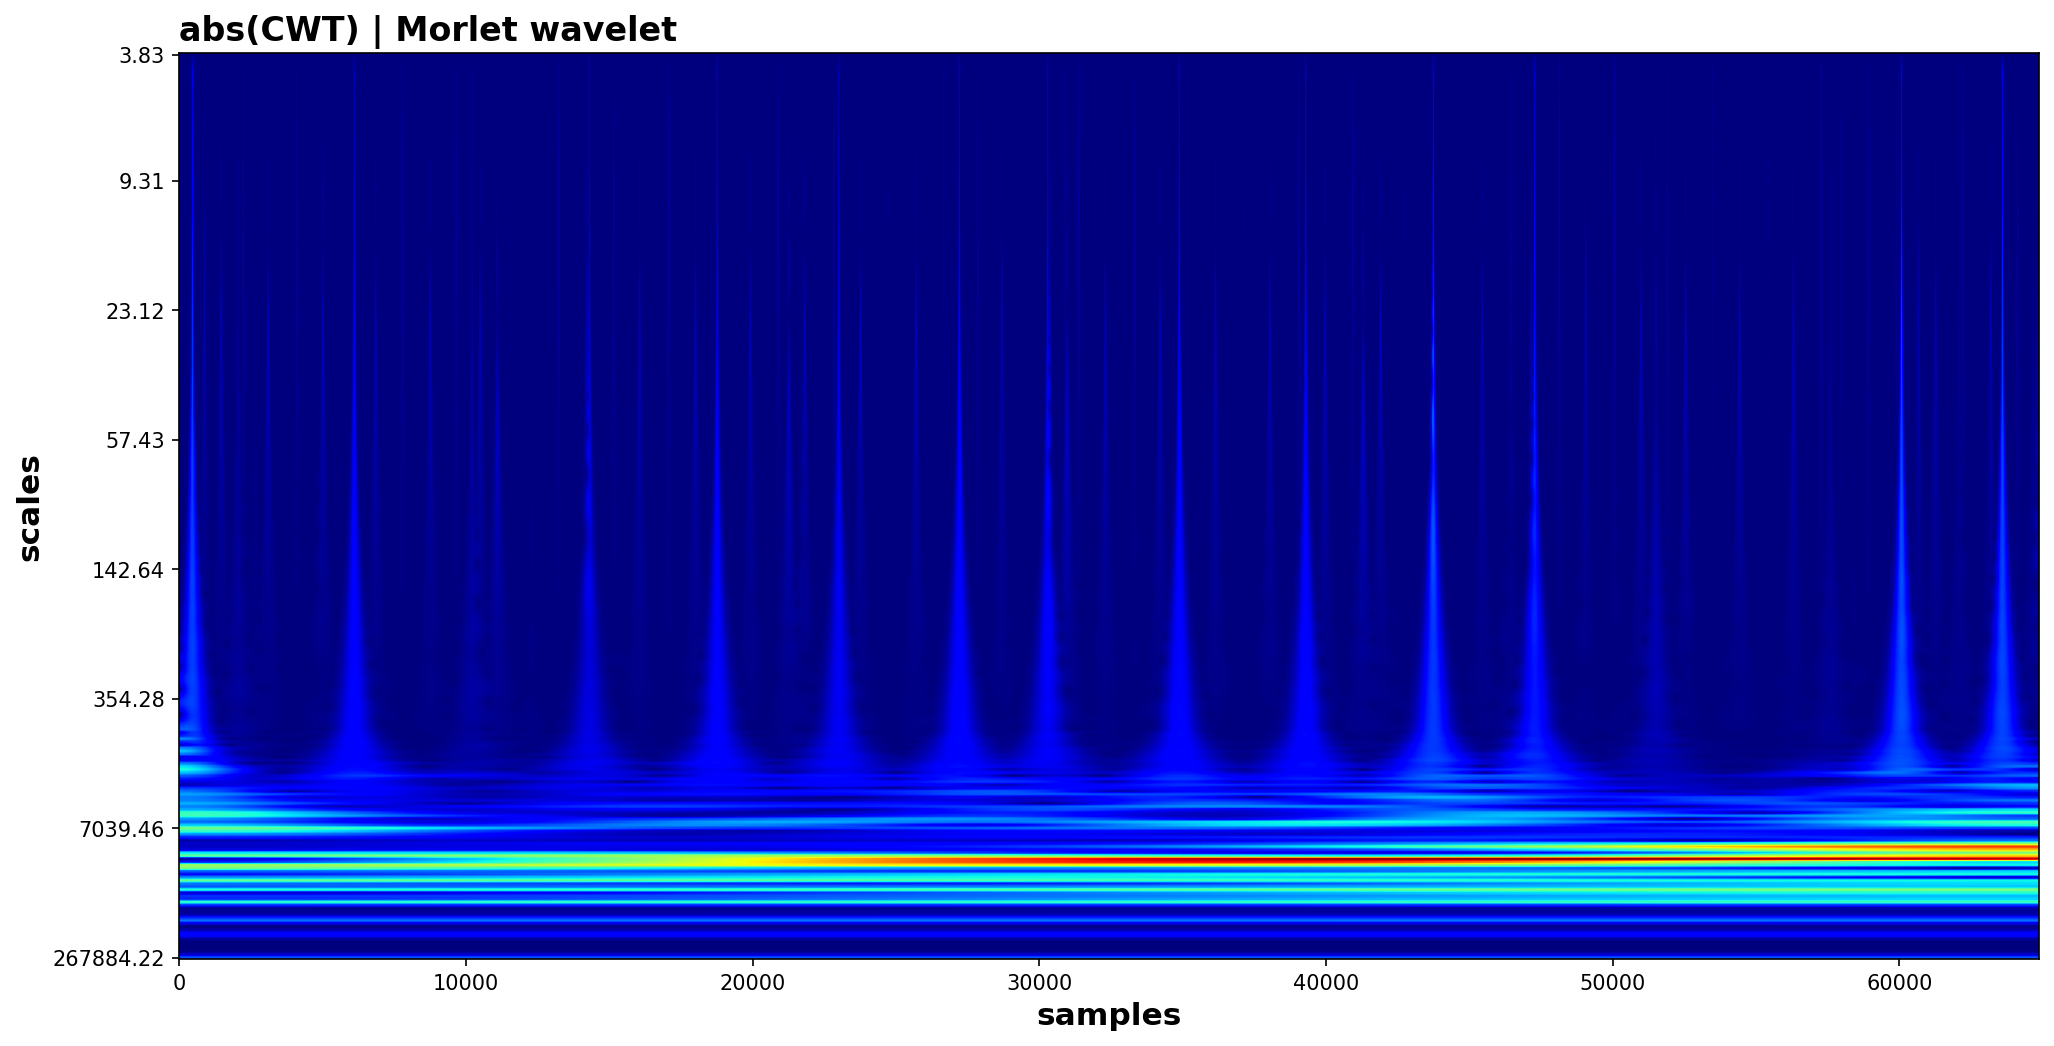

In [61]:
Wx, scales = cwt(np.array(lc.sap_flux), 'morlet')
plt.figure(figsize=(16, 8))
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

In [62]:
df = pd.DataFrame(np.array(lc), columns=lc.columns).applymap(lambda x: x.value if type(x) == astropy.time.core.Time else float(x)).set_index("time")
df

,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
time,,,,,,,,,,,,,,,,,,,,,,,,
120.538886,1.000647,0.000058,0.0,0.000734,860.282480,250.684195,568.0,246008.656250,14.304771,2444.200928,0.951010,275843.81250,16.083908,0.0,NaN,NaN,NaN,NaN,860.282480,0.000063,250.684195,0.000082,0.002059,-0.000301
120.559321,1.000848,0.000058,8192.0,0.000735,860.282752,250.684363,569.0,246026.578125,14.305067,2443.525391,0.950614,275899.18750,16.032907,8192.0,NaN,NaN,NaN,NaN,860.282752,0.000063,250.684363,0.000082,0.002261,0.000120
120.579755,1.000744,0.000058,0.0,0.000735,860.283020,250.684440,570.0,246071.812500,14.304944,2441.487305,0.951063,275870.68750,16.047340,0.0,NaN,NaN,NaN,NaN,860.283020,0.000063,250.684440,0.000082,0.002587,0.000074
120.600189,1.001039,0.000058,0.0,0.000736,860.282968,250.684136,571.0,246032.515625,14.305176,2442.444092,0.950024,275951.96875,16.010960,0.0,NaN,NaN,NaN,NaN,860.282968,0.000063,250.684136,0.000082,0.002573,-0.000261
120.620623,1.000449,0.000058,0.0,0.000736,860.283634,250.684470,572.0,246054.531250,14.304453,2444.509277,0.950191,275789.37500,15.987593,0.0,NaN,NaN,NaN,NaN,860.283634,0.000063,250.684470,0.000082,0.003339,0.000141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590.919703,1.009704,0.000059,0.0,0.000285,860.210924,250.690193,72527.0,261682.703125,15.233678,4354.244141,1.609021,268230.15625,15.697400,0.0,NaN,NaN,NaN,NaN,860.210924,0.000082,250.690193,0.000100,0.004805,0.032989
1590.940137,1.009738,0.000059,0.0,0.000285,860.210975,250.690220,72528.0,261704.453125,15.234119,4350.159180,1.607558,268239.34375,15.696334,0.0,NaN,NaN,NaN,NaN,860.210975,0.000082,250.690220,0.000100,0.004778,0.033148
1590.960571,1.009676,0.000059,0.0,0.000286,860.210807,250.690175,72529.0,261673.218750,15.233451,4355.228516,1.608858,268222.81250,15.697002,0.0,NaN,NaN,NaN,NaN,860.210807,0.000082,250.690175,0.000100,0.004590,0.032844


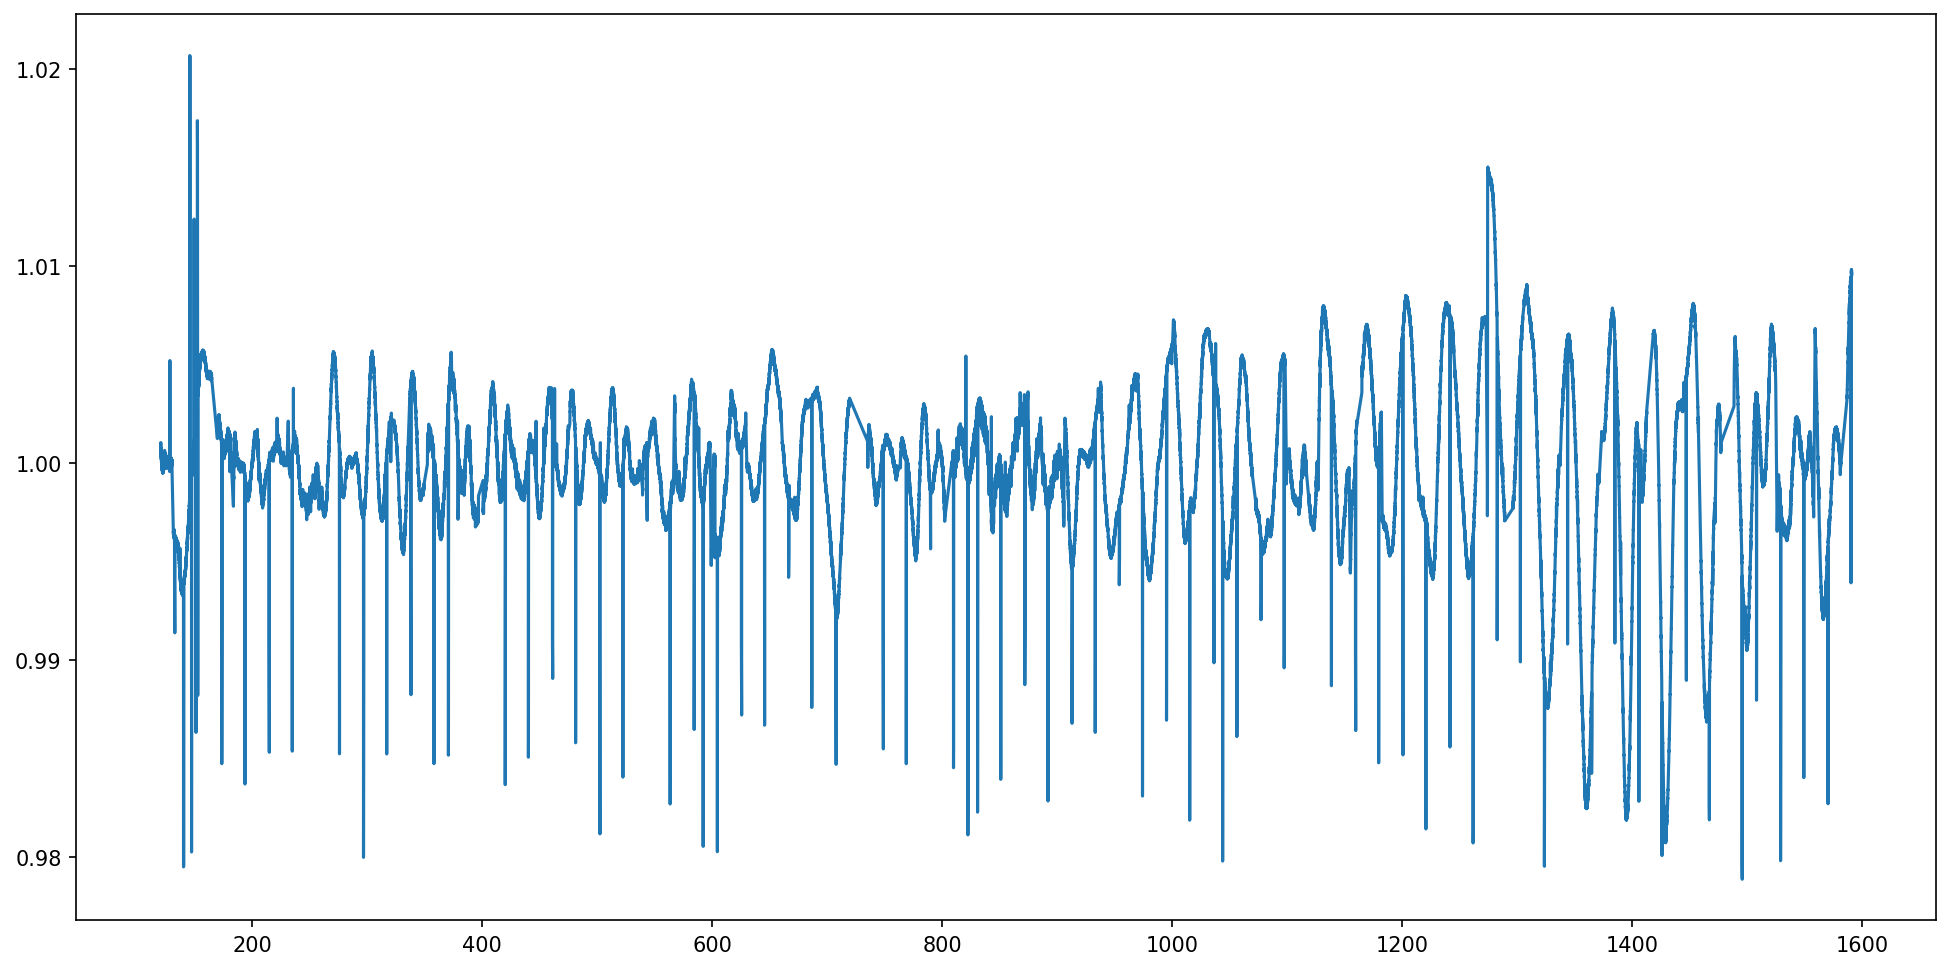

In [63]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df.flux)

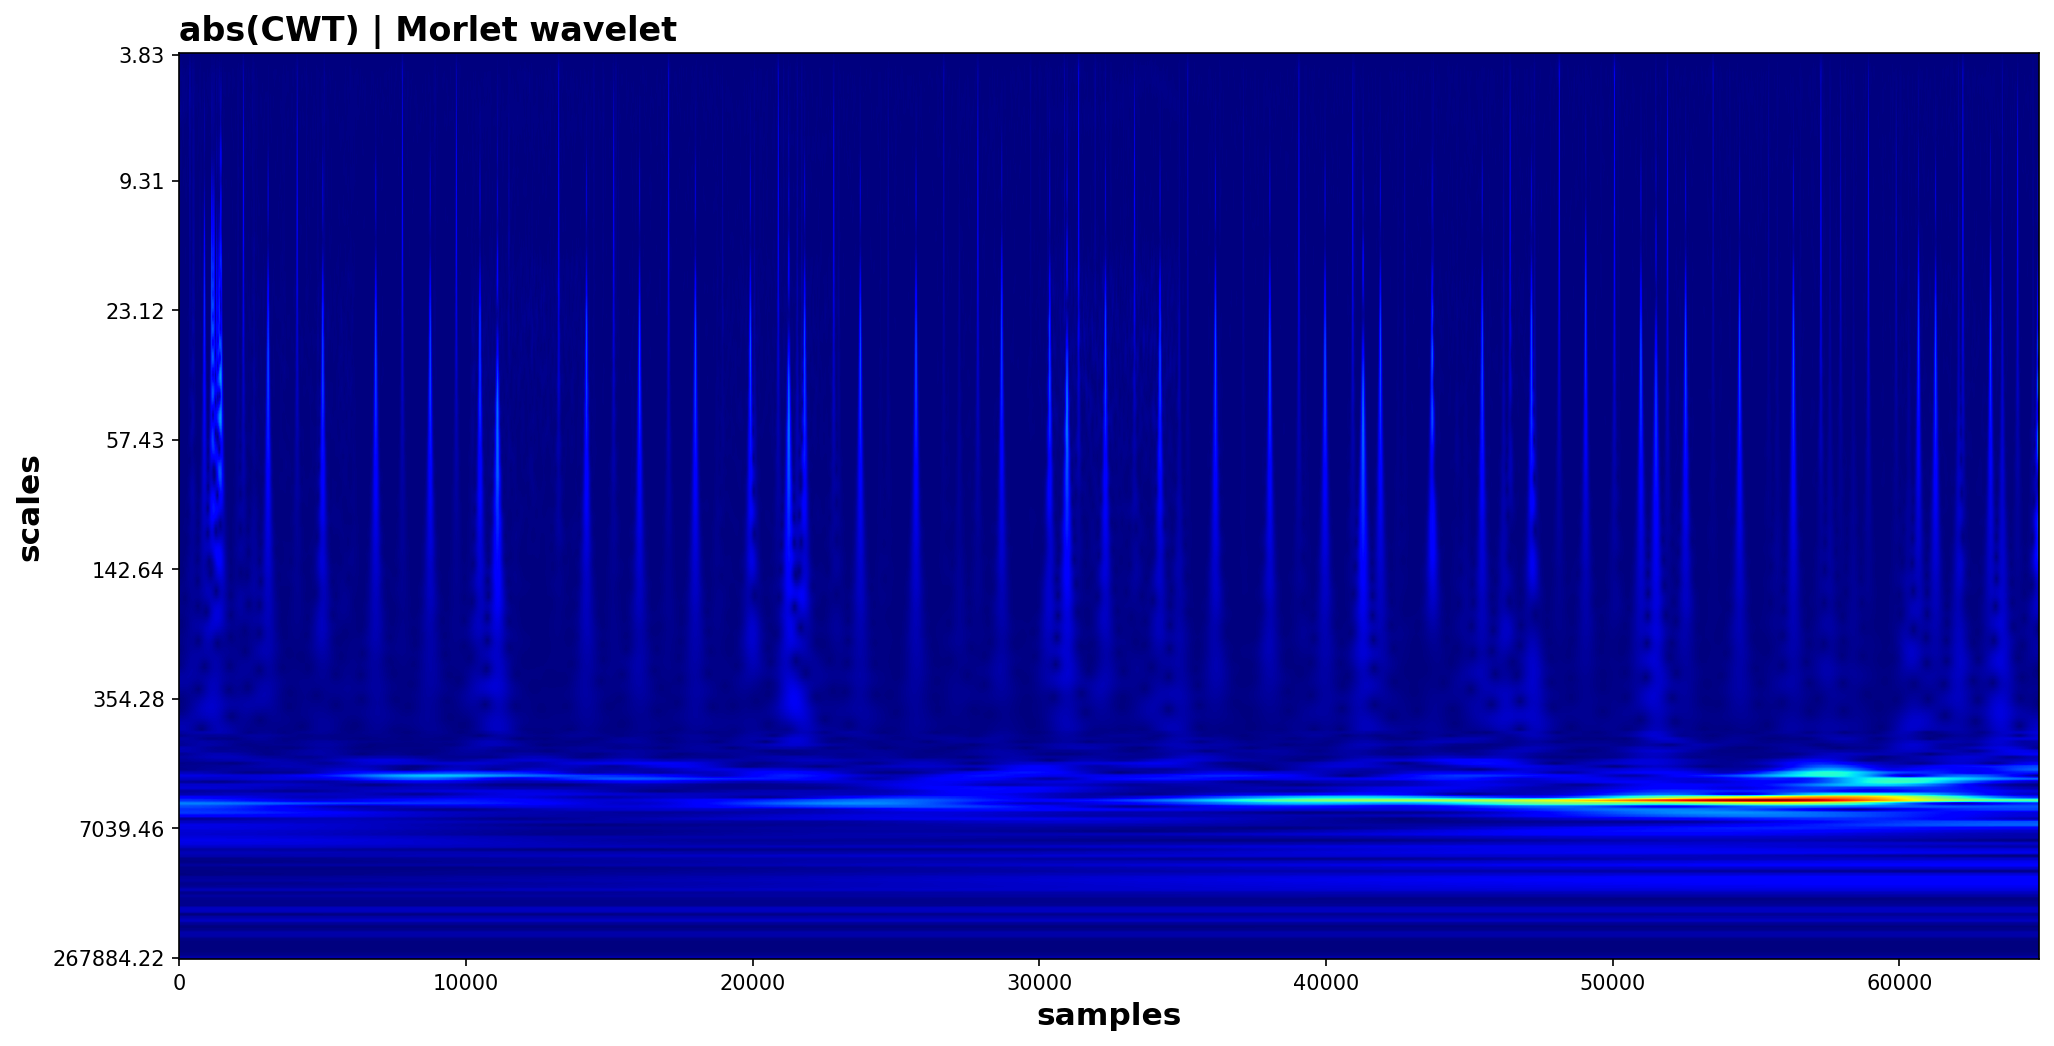

In [64]:
Wx, scales = cwt(df.flux.values, 'morlet')
plt.figure(figsize=(16, 8))
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

In [65]:
flatten_lc, trend_lc = wotan.flatten(df.index, df.flux, window_length=0.5, method='biweight', return_trend=True)
flatten_lc, trend_lc

(array([0.99995627, 1.00016625, 1.00006952, ..., 0.99999351, 0.9998247 ,
        0.99991874]),
 array([1.00069047, 1.00068122, 1.00067466, ..., 1.00968253, 1.0096781 ,
        1.00967708]))

In [66]:
df.loc[:, "trend"] = trend_lc
df.loc[:, "flattened"] = flatten_lc
df

,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,trend,flattened
time,,,,,,,,,,,,,,,,,,,,,,,,,,
120.538886,1.000647,0.000058,0.0,0.000734,860.282480,250.684195,568.0,246008.656250,14.304771,2444.200928,0.951010,275843.81250,16.083908,0.0,NaN,NaN,NaN,NaN,860.282480,0.000063,250.684195,0.000082,0.002059,-0.000301,1.000690,0.999956
120.559321,1.000848,0.000058,8192.0,0.000735,860.282752,250.684363,569.0,246026.578125,14.305067,2443.525391,0.950614,275899.18750,16.032907,8192.0,NaN,NaN,NaN,NaN,860.282752,0.000063,250.684363,0.000082,0.002261,0.000120,1.000681,1.000166
120.579755,1.000744,0.000058,0.0,0.000735,860.283020,250.684440,570.0,246071.812500,14.304944,2441.487305,0.951063,275870.68750,16.047340,0.0,NaN,NaN,NaN,NaN,860.283020,0.000063,250.684440,0.000082,0.002587,0.000074,1.000675,1.000070
120.600189,1.001039,0.000058,0.0,0.000736,860.282968,250.684136,571.0,246032.515625,14.305176,2442.444092,0.950024,275951.96875,16.010960,0.0,NaN,NaN,NaN,NaN,860.282968,0.000063,250.684136,0.000082,0.002573,-0.000261,1.000666,1.000373
120.620623,1.000449,0.000058,0.0,0.000736,860.283634,250.684470,572.0,246054.531250,14.304453,2444.509277,0.950191,275789.37500,15.987593,0.0,NaN,NaN,NaN,NaN,860.283634,0.000063,250.684470,0.000082,0.003339,0.000141,1.000669,0.999780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590.919703,1.009704,0.000059,0.0,0.000285,860.210924,250.690193,72527.0,261682.703125,15.233678,4354.244141,1.609021,268230.15625,15.697400,0.0,NaN,NaN,NaN,NaN,860.210924,0.000082,250.690193,0.000100,0.004805,0.032989,1.009681,1.000022
1590.940137,1.009738,0.000059,0.0,0.000285,860.210975,250.690220,72528.0,261704.453125,15.234119,4350.159180,1.607558,268239.34375,15.696334,0.0,NaN,NaN,NaN,NaN,860.210975,0.000082,250.690220,0.000100,0.004778,0.033148,1.009683,1.000055
1590.960571,1.009676,0.000059,0.0,0.000286,860.210807,250.690175,72529.0,261673.218750,15.233451,4355.228516,1.608858,268222.81250,15.697002,0.0,NaN,NaN,NaN,NaN,860.210807,0.000082,250.690175,0.000100,0.004590,0.032844,1.009683,0.999994


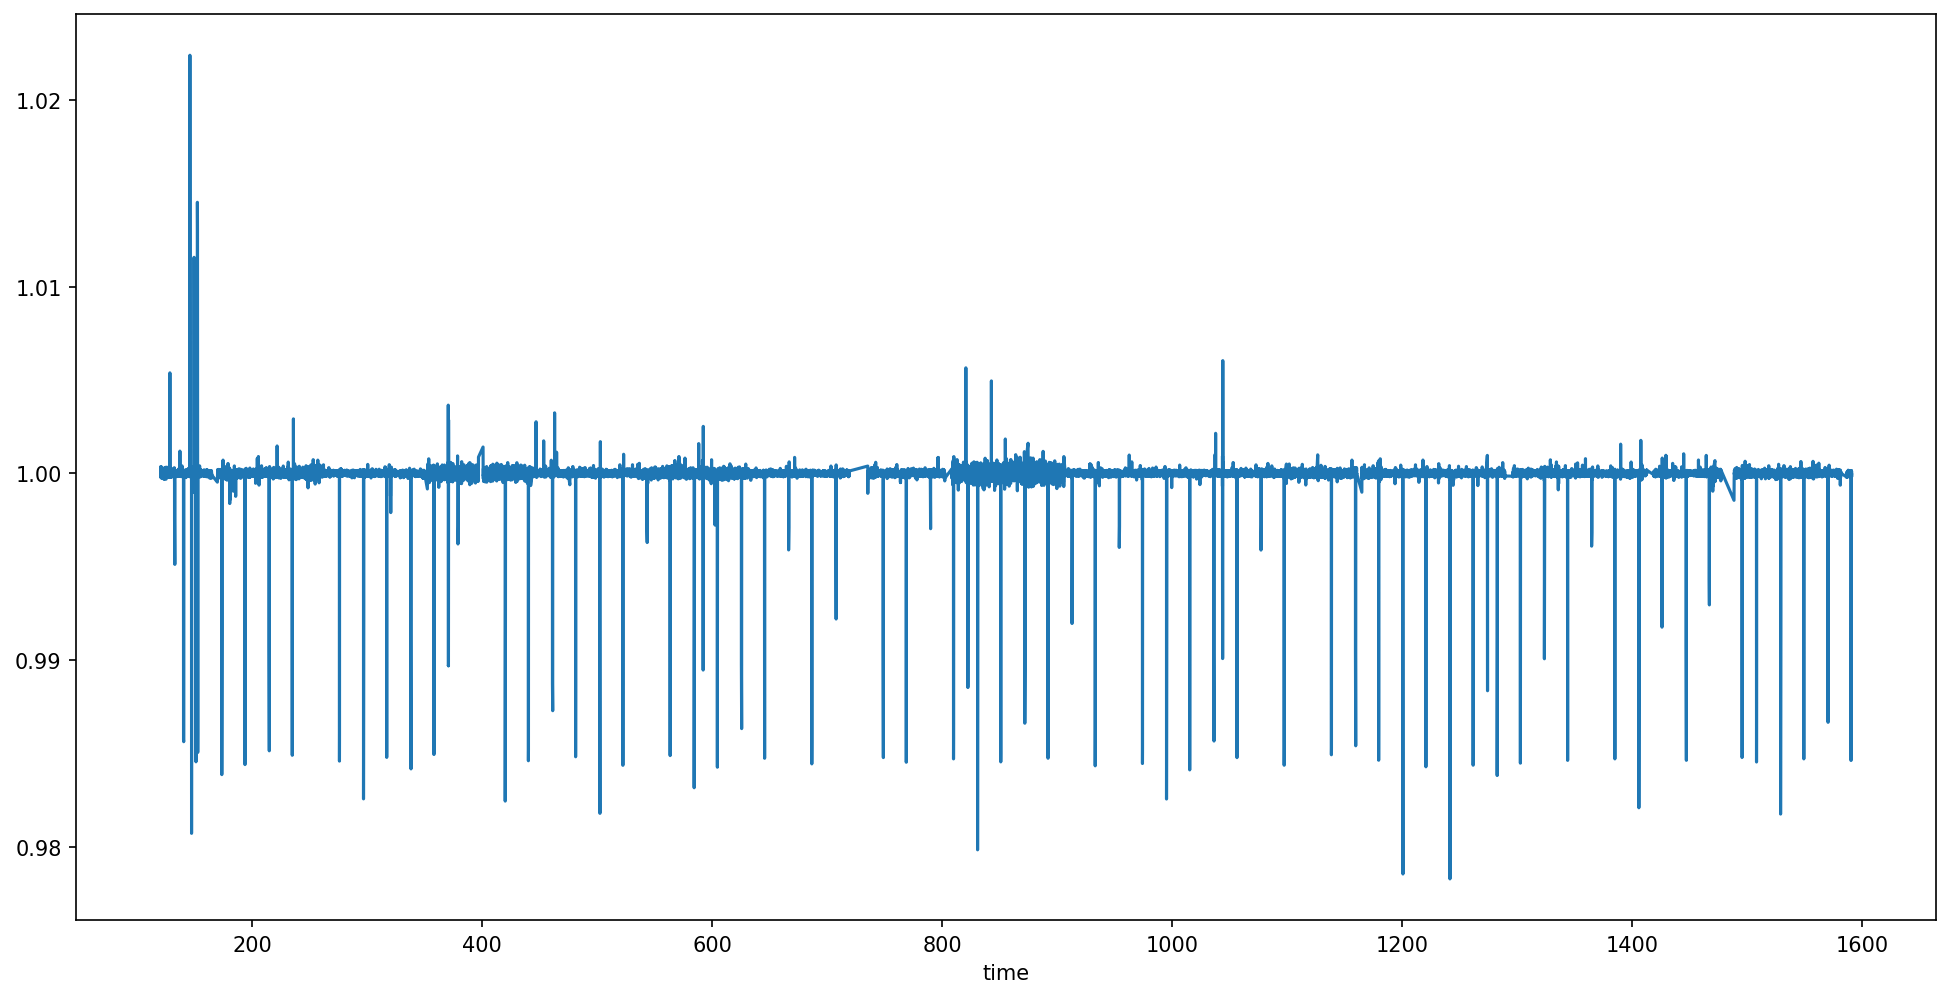

In [67]:
df.flattened.plot(figsize=(16, 8))

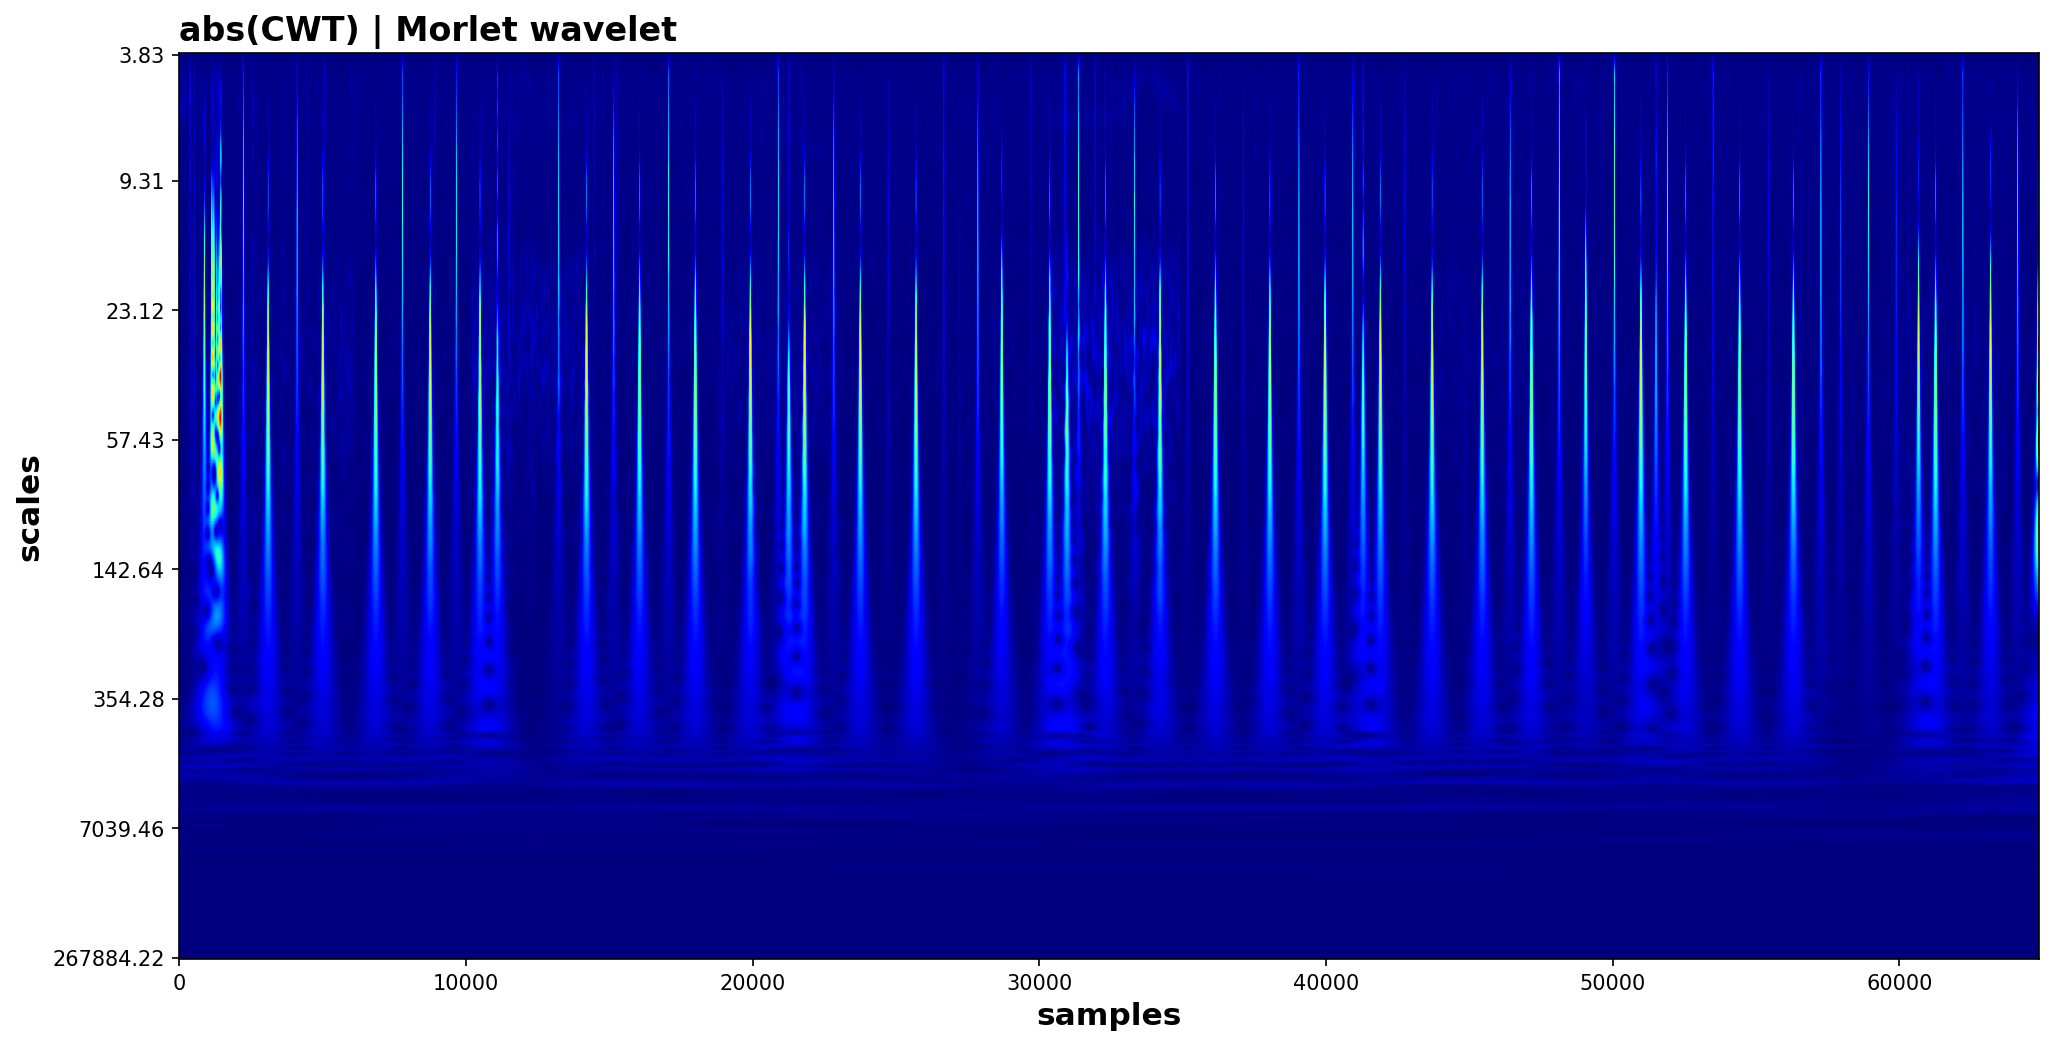

In [68]:
Wx, scales = cwt(df.flattened.values, 'morlet')
plt.figure(figsize=(16, 8))
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

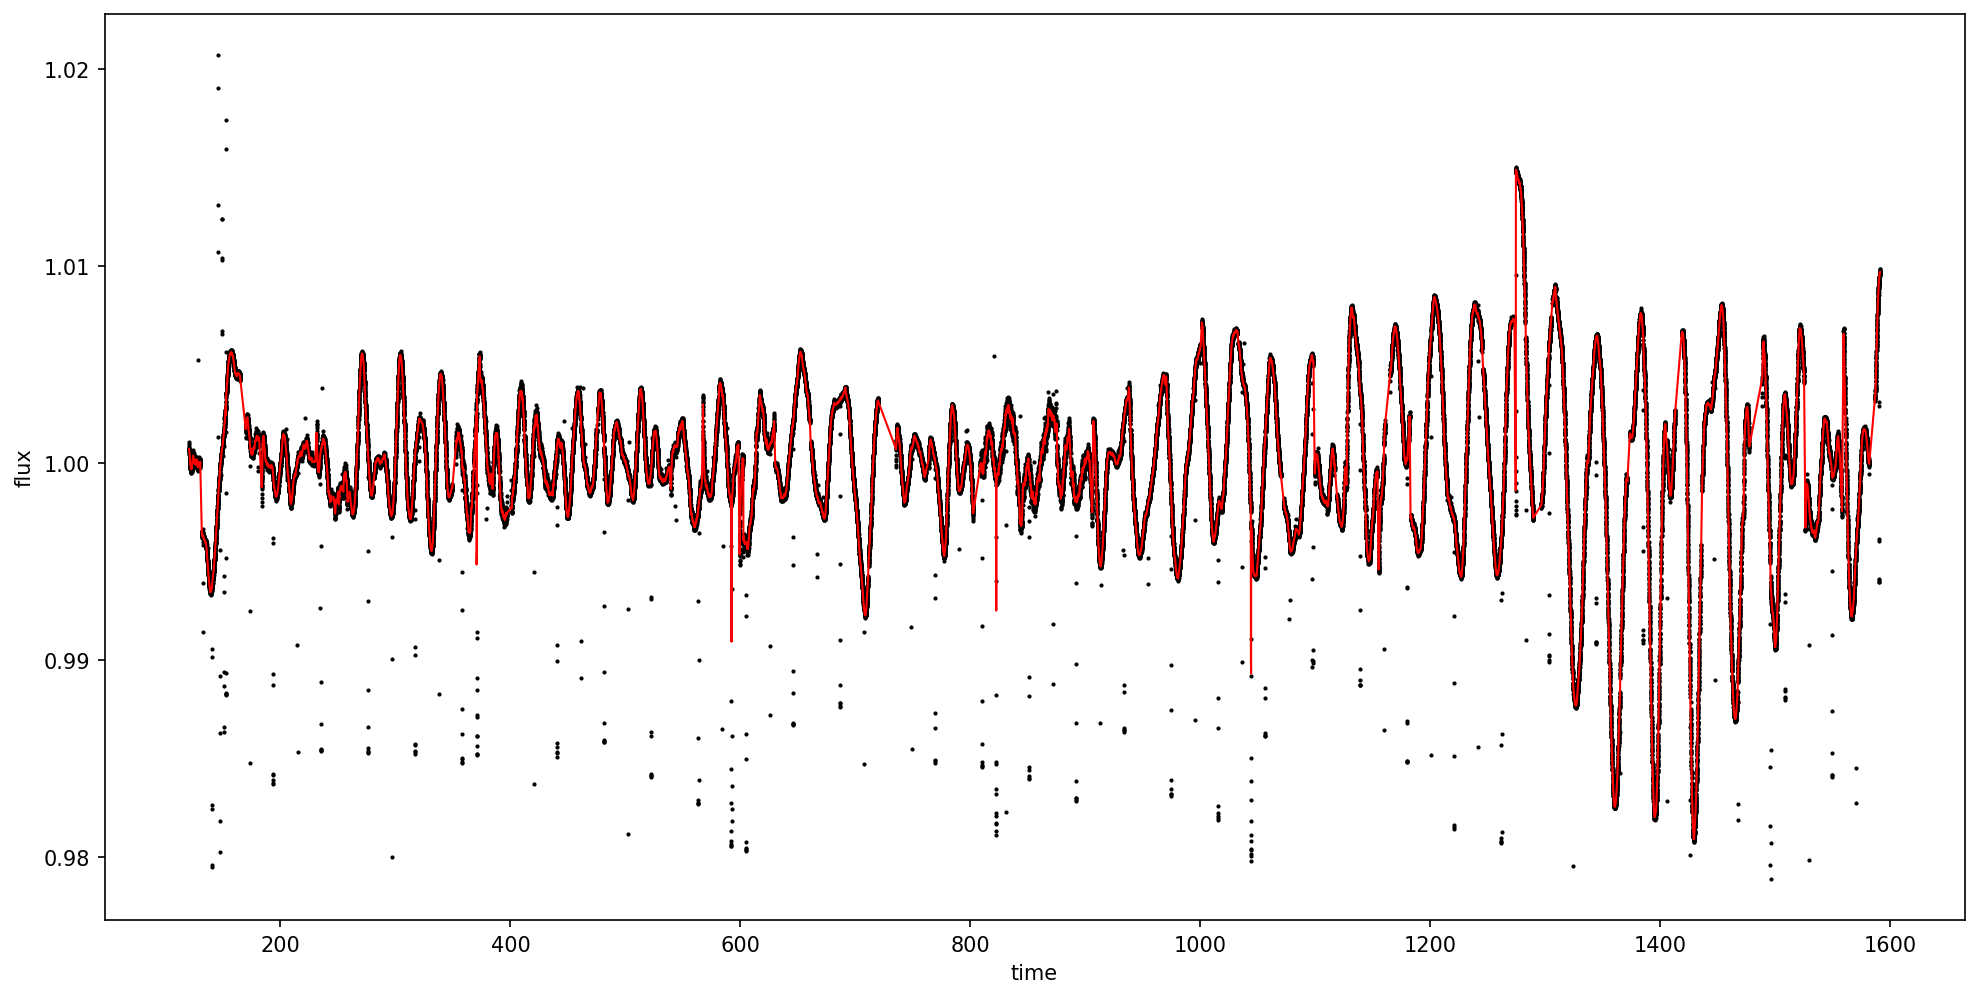

In [69]:
ax = df.reset_index().plot(kind="scatter", figsize=(16, 8), y="flux", x="time", s=1, color='black')
df.trend.plot(figsize=(16, 8), ax=ax, color='red', linewidth=1)

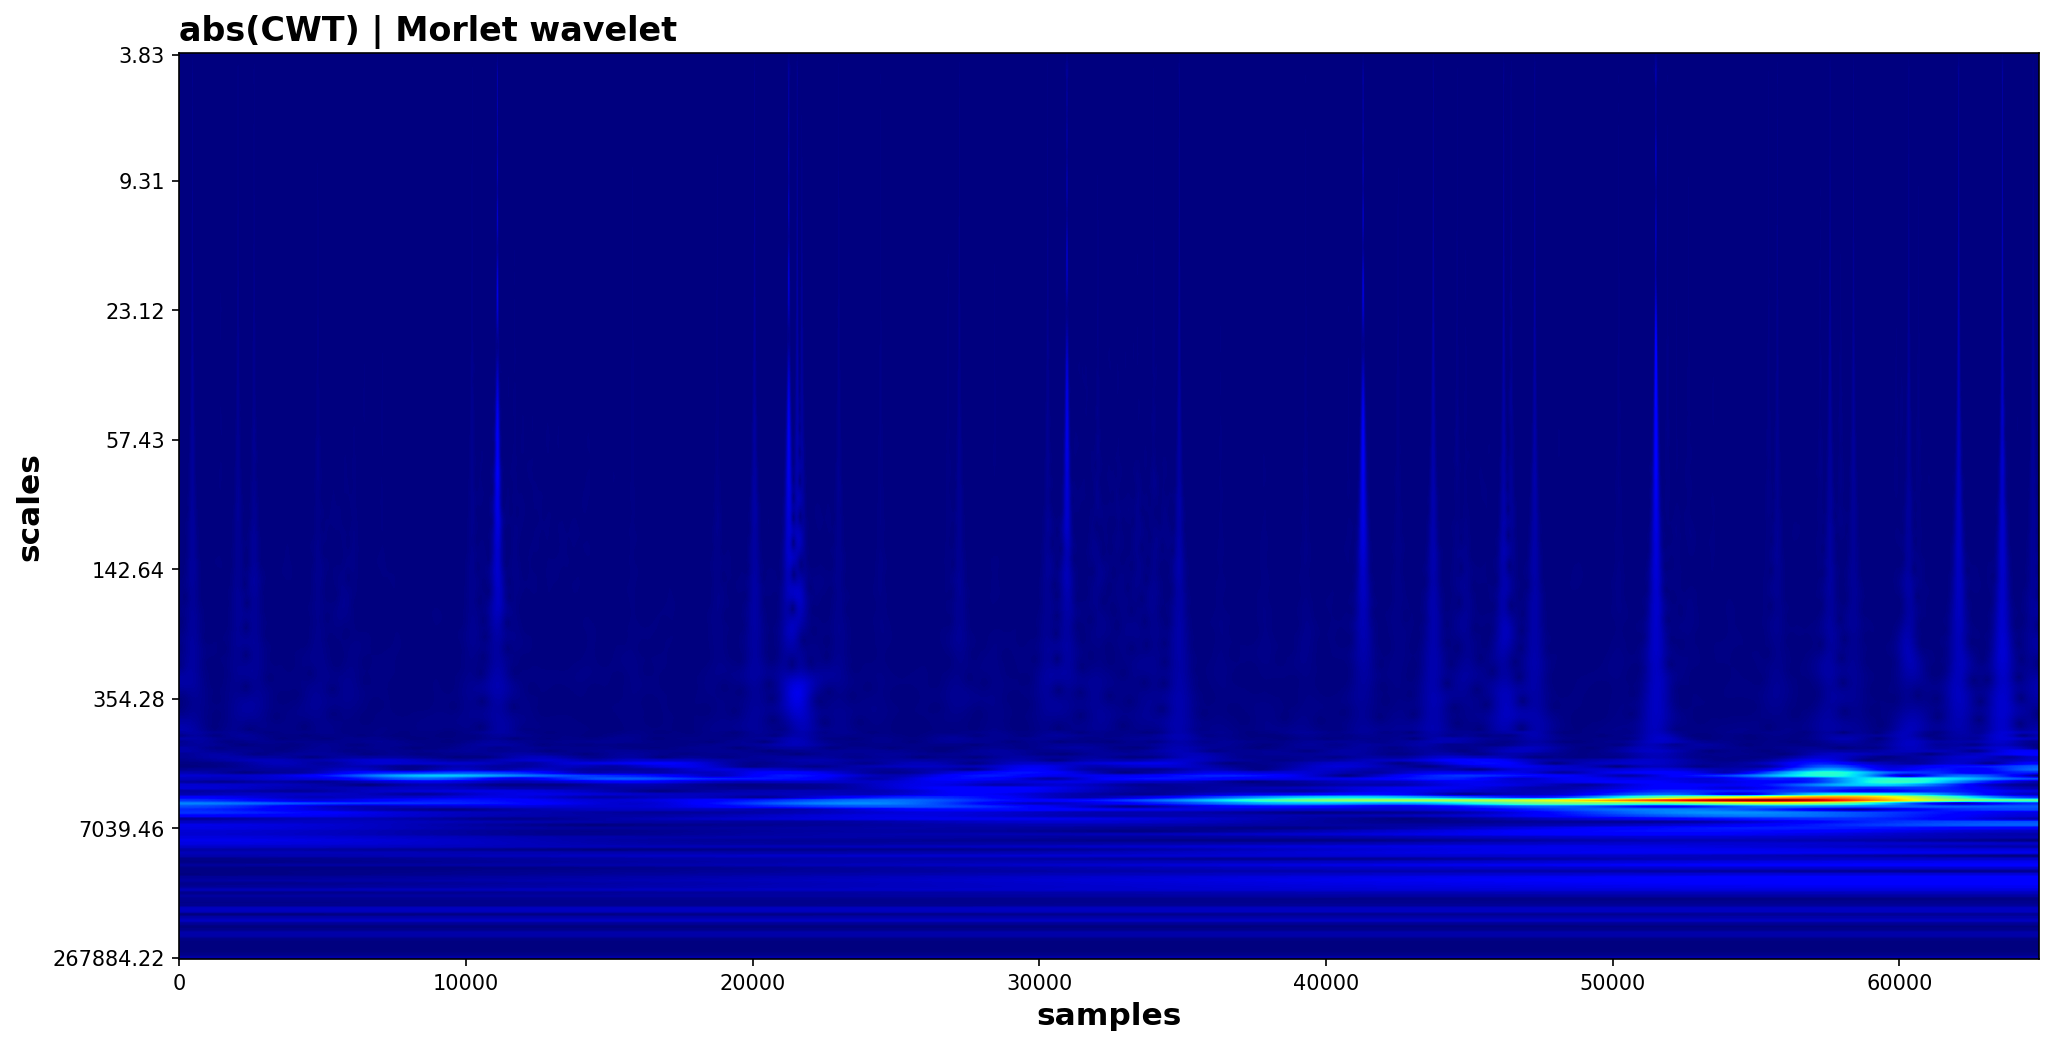

In [70]:
Wx, scales = cwt(df.trend.values, 'morlet')
plt.figure(figsize=(16, 8))
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

In [ ]:
model = tls(df.index.values, df.flattened.values)
results = model.power()

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 66 durations
Searching 64887 data points, 187932 periods from 0.602 to 735.231 days
Using all 2 CPU threads


 94%|█████████▍| 176664/187932 periods | 4:50:10<17:42

In [ ]:
print("Hello")

In [38]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE TLS')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

{'FAP': 8.0032e-05,
 'SDE': 37.28846768749527,
 'SDE_raw': 30.50228142723412,
 'SR': array([0.9546815 , 0.95356422, 0.95360378, ..., 0.95705148, 0.95878733,
        0.95773646]),
 'T0': 353.53397822827264,
 'after_transit_count': 0,
 'before_transit_count': 43,
 'chi2': array([3941.52188908, 3946.14013629, 3945.97641045, ..., 3931.76136658,
        3924.64307007, 3928.9493373 ]),
 'chi2_min': 3762.898031817695,
 'chi2red': array([0.99886515, 1.00003551, 0.99999402, ..., 0.99639163, 0.9945877 ,
        0.995679  ]),
 'chi2red_min': 0.9535980820622644,
 'depth': 0.9995715433379507,
 'depth_mean': (0.9996558013937914, 5.596248379116031e-05),
 'depth_mean_even': (0.9996860433480556, 7.237276079951267e-05),
 'depth_mean_odd': (0.9996255594395272, 8.46092676789731e-05),
 'distinct_transit_count': 24,
 'duration': 0.03500152792419483,
 'empty_transit_count': 2,
 'folded_dy': array([0.00017561, 0.00017561, 0.00017561, ..., 0.00017561, 0.00017561,
        0.00017561]),
 'folded_phase': array([7

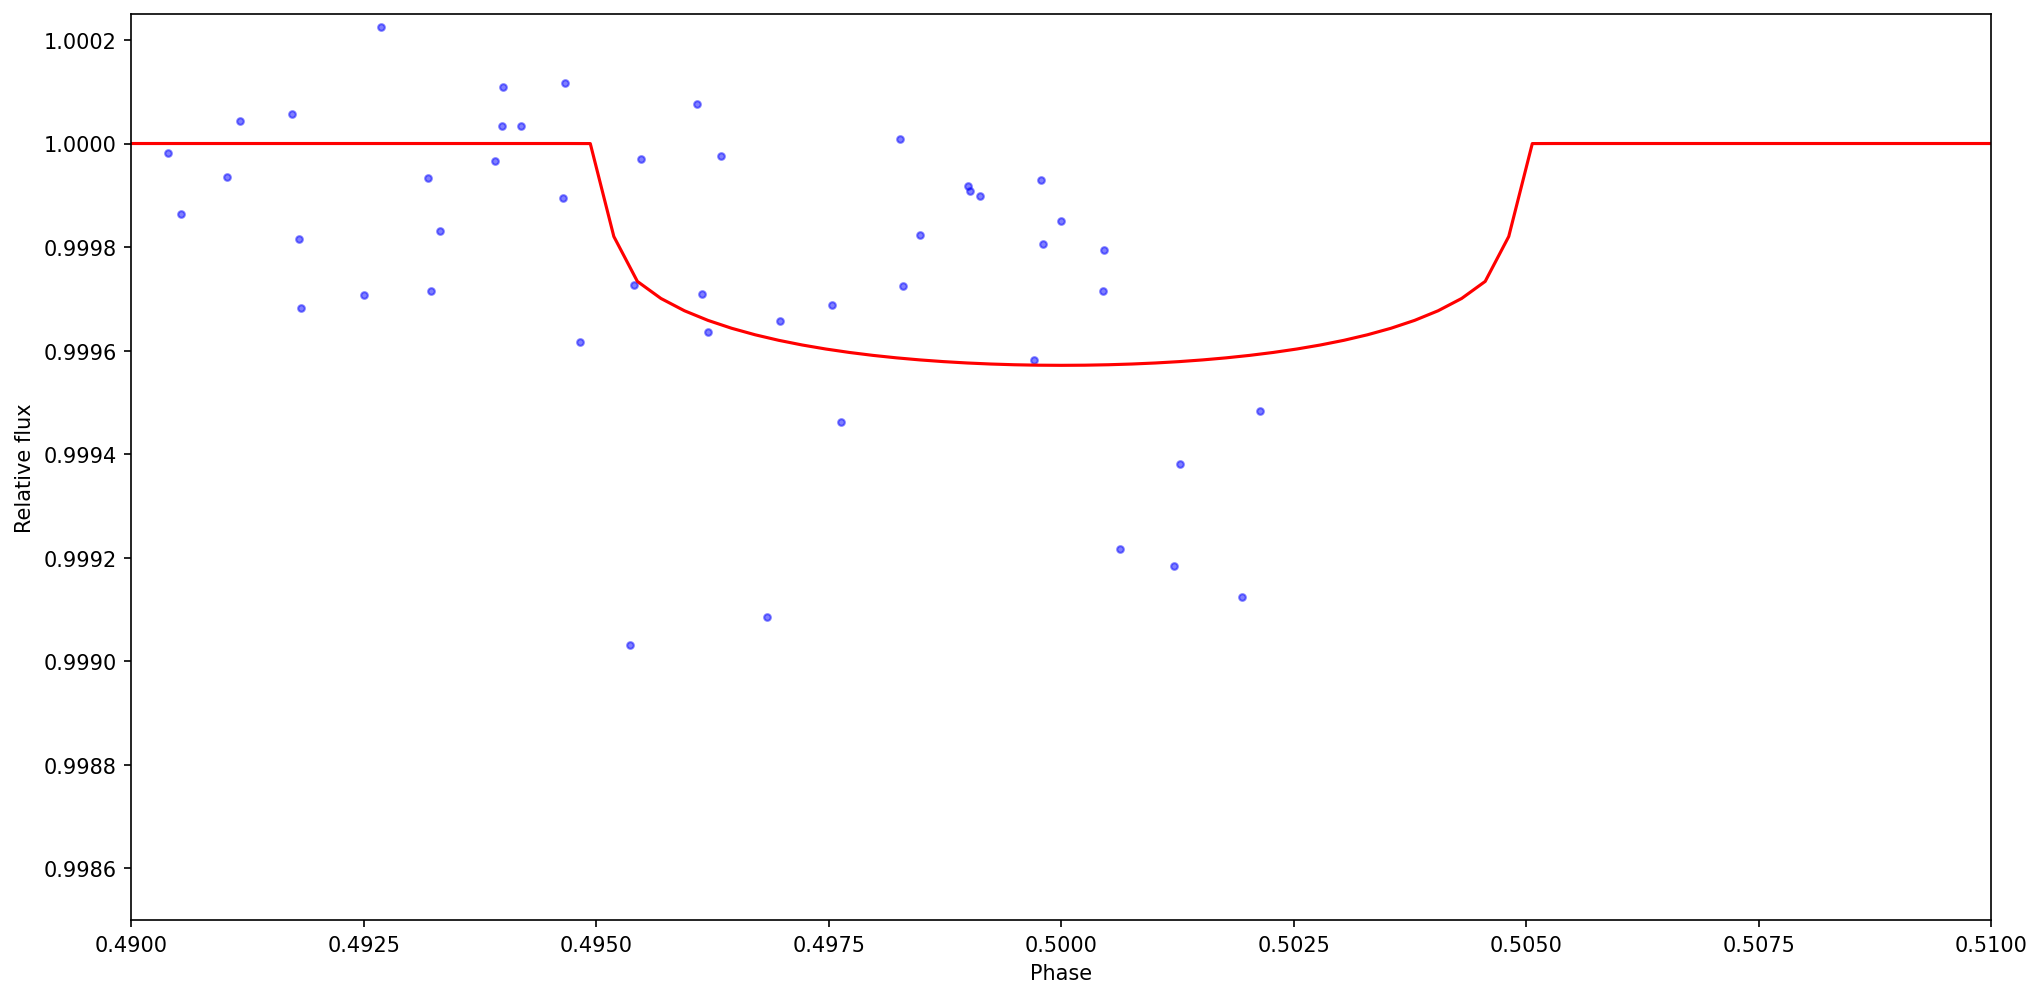

In [40]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150



plt.figure(figsize=(16, 8))
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red')
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.49, 0.51)
plt.ylim(0.9985, 1.00025)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [27]:
df_pre_400 = df[df.index < 400]
df_pre_400

,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
time,,,,,,,,,,,,,,,,,,,,,,,,
352.396758,52490.750000,8.000313,8192.0,-0.001411,682.690844,190.132704,11915.0,43698.070312,6.646242,1669.839966,0.467649,52490.750000,8.000313,8192.0,682.609001,0.000078,190.367766,0.000118,682.690844,0.000186,190.132704,0.000183,0.098700,-0.172299
352.437624,52484.054688,7.999979,16.0,-0.001412,682.690381,190.133024,11917.0,43694.105469,6.646162,1673.130615,0.467055,52484.054688,7.999979,16.0,682.608625,0.000078,190.368479,0.000118,682.690381,0.000186,190.133024,0.000183,0.098307,-0.171802
352.458058,52491.808594,8.000620,0.0,-0.001412,682.690839,190.132567,11918.0,43698.316406,6.646313,1674.140625,0.466878,52491.808594,8.000620,0.0,682.608724,0.000078,190.367920,0.000118,682.690839,0.000186,190.132567,0.000183,0.098410,-0.172030
352.478491,52478.277344,7.999273,0.0,-0.001413,682.689486,190.133042,11919.0,43687.648438,6.645916,1672.381470,0.467646,52478.277344,7.999273,0.0,682.608290,0.000078,190.368136,0.000118,682.689486,0.000186,190.133042,0.000183,0.098039,-0.171838
352.498924,52475.855469,7.998662,0.0,-0.001413,682.690358,190.133177,11920.0,43686.480469,6.645871,1673.437500,0.468172,52475.855469,7.998662,0.0,682.608523,0.000078,190.368750,0.000118,682.690358,0.000186,190.133177,0.000183,0.098103,-0.171517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396.757954,52491.148438,8.014248,0.0,-0.001558,682.583055,190.244803,14086.0,43533.105469,6.648554,1791.982300,0.470106,52491.148438,8.014248,0.0,682.504686,0.000065,190.544201,0.000117,682.583055,0.000186,190.244803,0.000185,0.000221,-0.000055
396.778388,52488.289062,8.014027,0.0,-0.001558,682.582453,190.244841,14087.0,43527.503906,6.648354,1791.248169,0.470594,52488.289062,8.014027,0.0,682.504652,0.000065,190.543829,0.000118,682.582453,0.000186,190.244841,0.000185,0.000325,-0.000496
396.798822,52483.671875,8.010699,0.0,-0.001557,682.582856,190.245230,14088.0,43524.226562,6.648343,1792.085449,0.470445,52483.671875,8.010699,0.0,682.504544,0.000065,190.544255,0.000117,682.582856,0.000186,190.245230,0.000185,0.000066,-0.000101


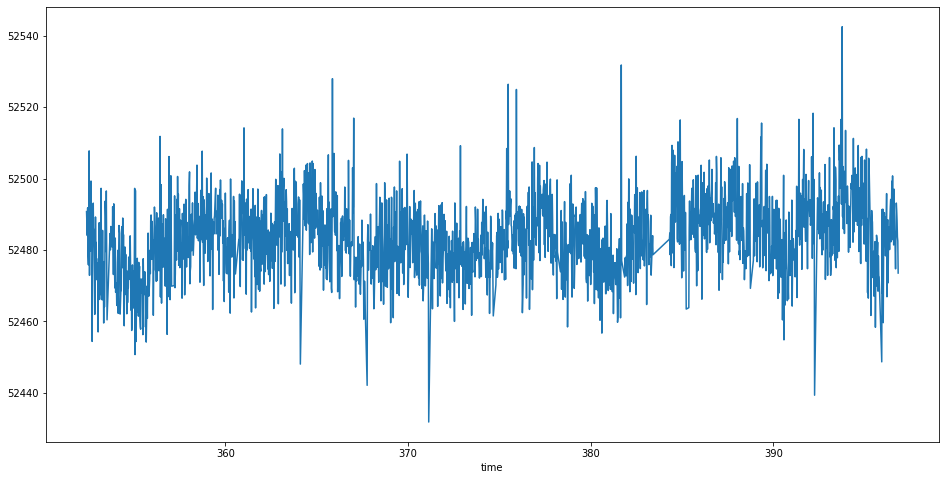

In [34]:
df_pre_400.flux.plot(figsize=(16, 8))

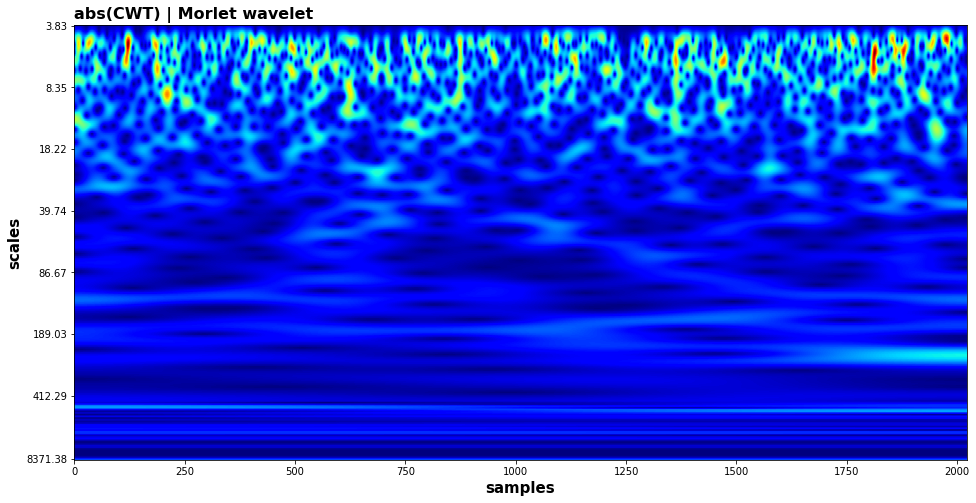

In [31]:
Wx, scales = cwt(df_pre_400.flux.values, 'morlet')
plt.figure(figsize=(16, 8))
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

In [28]:
df_post_400 = df[df.index > 400]
df_post_400

,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
time,,,,,,,,,,,,,,,,,,,,,,,,
400.824301,52479.140625,8.003036,0.0,-0.001498,682.567381,190.261591,14285.0,43517.855469,6.652475,1777.776245,0.470597,52479.140625,8.003036,0.0,682.490904,0.000064,190.567765,0.000111,682.567381,0.000186,190.261591,0.000185,-0.014195,0.022968
400.844735,52491.546875,8.004422,0.0,-0.001498,682.567681,190.261744,14286.0,43528.984375,6.652837,1776.755615,0.470052,52491.546875,8.004422,0.0,682.490765,0.000064,190.567997,0.000110,682.567681,0.000186,190.261744,0.000185,-0.014343,0.023176
400.865169,52475.167969,8.006420,0.0,-0.001498,682.567052,190.261503,14287.0,43516.000000,6.652233,1776.987549,0.470019,52475.167969,8.006420,0.0,682.490517,0.000064,190.568097,0.000110,682.567052,0.000186,190.261503,0.000185,-0.014433,0.023406
400.885603,52498.910156,8.005615,0.0,-0.001497,682.567041,190.261907,14288.0,43535.410156,6.653096,1776.238037,0.469890,52498.910156,8.005615,0.0,682.490611,0.000064,190.568280,0.000110,682.567041,0.000186,190.261907,0.000185,-0.014400,0.023386
400.906037,52477.027344,8.005366,0.0,-0.001497,682.567248,190.261856,14289.0,43518.003906,6.652301,1775.540649,0.470620,52477.027344,8.005366,0.0,682.490609,0.000064,190.567999,0.000110,682.567248,0.000186,190.261856,0.000185,-0.014346,0.023484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442.121767,52479.808594,7.970259,8192.0,-0.000337,682.491449,190.344132,16306.0,43160.660156,6.614146,1499.907104,0.466483,52479.808594,7.970259,8192.0,682.423116,0.000073,190.685158,0.000093,682.491449,0.000185,190.344132,0.000187,-0.079732,0.138862
442.142201,52475.605469,7.971237,0.0,-0.000336,682.491241,190.344875,16307.0,43157.628906,6.613934,1498.131470,0.466943,52475.605469,7.971237,0.0,682.422824,0.000073,190.685560,0.000093,682.491241,0.000185,190.344875,0.000187,-0.079895,0.139143
442.162635,52475.304688,7.970731,0.0,-0.000336,682.491037,190.344600,16308.0,43155.800781,6.613858,1498.294556,0.467785,52475.304688,7.970731,0.0,682.422877,0.000073,190.685004,0.000093,682.491037,0.000185,190.344600,0.000187,-0.079854,0.138774


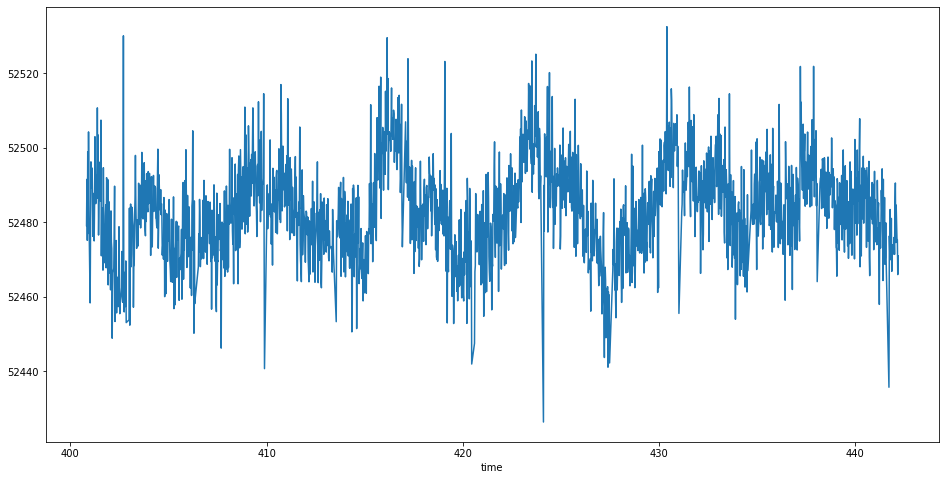

In [35]:
df_post_400.flux.plot(figsize=(16, 8))

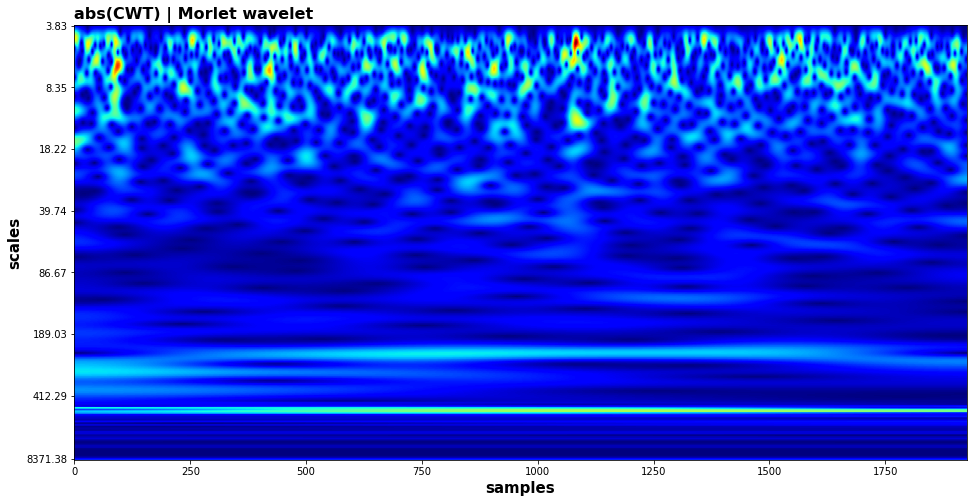

In [36]:
Wx, scales = cwt(df_post_400.flux.values, 'morlet')
plt.figure(figsize=(16, 8))
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")